In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# model
from tensorflow.keras.models import Sequential, Model
# layers
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.layers import Conv1D, LSTM, Embedding
# optimizers
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop

# preprocessing data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# prepare the dataset
import tensorflow_datasets as tfds

# additional import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# dataset source: http://help.sentiment140.com/for-students/
!wget "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"

--2020-03-22 08:54:32--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-03-22 08:54:32--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  21.2MB/s    in 4.5s    

2020-03-22 08:54:37 (17.4 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [0]:
# Extract the zip file
from zipfile import ZipFile
with ZipFile('trainingandtestdata.zip', 'r') as obj:
  obj.extractall('dataset')

In [5]:
# Read the processed data
df = pd.read_csv('dataset/training.1600000.processed.noemoticon.csv', header = None, encoding = 'ISO-8859-1')
df.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.tail()

,0,1,2,3,4,5
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [0]:
# updating columns
df.columns = ['Polarity', 'ID', 'Date', 'Query', 'Username', 'Tweet']

In [8]:
df.sample(5)

,Polarity,ID,Date,Query,Username,Tweet
1067185,4,1965448606,Fri May 29 15:56:28 PDT 2009,NO_QUERY,juliegoolie,Figured chilling on union square was more inte...
894834,4,1692450589,Sun May 03 20:01:23 PDT 2009,NO_QUERY,cartoonworldvgm,has discovered that Bring Me the Horizon has a...
958154,4,1825658808,Sun May 17 06:26:50 PDT 2009,NO_QUERY,carole29,Big Bang Theory : Pumpernickel = Fart Goblin. ...
1331240,4,2015968969,Wed Jun 03 05:54:31 PDT 2009,NO_QUERY,imbize,"@kismet100 In my defense, he wasn't AT the res..."
1450266,4,2062923992,Sun Jun 07 00:45:31 PDT 2009,NO_QUERY,IvonneMenk,@jordanknight we have 9.45 am...but we are in ...


In [9]:
# First of all, all we need is Polarity and the Tweet, so I can drop the others
df = df.drop(['ID','Date', 'Query', 'Username'], axis = 1)
df.head()

,Polarity,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# TODO

Now we can work freely on the data, let's start with TODO list:
### Part 1: Preprocessing
1. Remove the links and the mentioned usernames
2. Filter the tweets with meanless symbols (because that kind of symbols won't provide any information)
3. Tokenize the tweets
4. Add padding
5. Split the dataset

### Part 2: Building the models
1. Build different LSTM and CNN models
2. Train the models
3. Compare the models by optimizer, epochs, stacking etc.

### Part 3: Test the model on real-world data
1. Collect a bunch of different tweets from twitter
2. Test the model!


# Preprocessing
I'll use sub-lists for specifying more details about TODO list. First, i'll be using tensorflow.data to create data pipelines

1. Remove the links and the mentioned usernames
  - I can use Regex, 
  - Also I can create functions manually to process the data
  - I hate regex, so let's do with second way.
  - To remove usernames, I can split the dataset and remove the "@" character from specific sub-string
  - Same approach can be used to remove the links
2. Filter the tweets with meanless symbols
  - I can remove every special character from the string with Regex
  - Also I can use simple filter with by filtering characters by ascii values

In [0]:
# Preprocessing the text
def preprocess_text(row):
  splitted_row = row.split(' ')
  for r in range(len(splitted_row)):  
    # remove nicknames
    if "@" in splitted_row[r]:
      splitted_row[r] = ""
    # remove links
    if ("http" or ".com") in splitted_row[r]:
      splitted_row[r] = ""

  return " ".join(splitted_row)

In [0]:
df['Tweet'] = df['Tweet'].apply(preprocess_text) # process everything we have

In [12]:
print(df['Polarity'].unique()) # Only unique values are 0 and 4 so I'll convert 4 to 1 in order to make binary classification
df['Polarity'] = df['Polarity'].apply(lambda x: 1 if x>=1 else 0)
df['Polarity'].unique()

[0 4]


array([0, 1])

In [13]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(df['Tweet'], df['Polarity'])
# Tokenization
MAX_VOCAB_SIZE = 30000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

# word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found {} unique tokens.'.format(V))

Found 263653 unique tokens.


In [0]:
data_train = pad_sequences(sequences_train)
print('Shape of the data_train: ', data_train.shape)
T = data_train.shape[1]

Shape of the data_train:  (1200000, 117)


In [0]:
data_test = pad_sequences(sequences_test, maxlen = T)
print('Shape of the data_test: ', data_test.shape)

Shape of the data_test:  (400000, 117)


In [0]:
# Create the model

# We get to choose embedding dimensionality
D = 20 # hyperparameter
# Hidden state dimensionality
M = 15 # hyperparameter

# NOTE: We actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0
# Thus, if the final index of the embedding matrix is V,
# then it actually must've size V + 1,

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = LSTM(M, return_sequences=True)(x)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i,x)

# Compile and fit
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

r = model.fit(data_train, y_train, validation_data = (data_test, y_test), batch_size = 48000, epochs = 40)


Train on 1200000 samples, validate on 400000 samples
Epoch 1/40
1200000/1200000 [==============================] - 32s 27us/sample - loss: 0.6921 - accuracy: 0.5404 - val_loss: 0.6887 - val_accuracy: 0.5955
Epoch 2/40
1200000/1200000 [==============================] - 23s 19us/sample - loss: 0.6702 - accuracy: 0.6370 - val_loss: 0.6402 - val_accuracy: 0.6516
Epoch 3/40
1200000/1200000 [==============================] - 23s 19us/sample - loss: 0.6314 - accuracy: 0.6485 - val_loss: 0.6099 - val_accuracy: 0.6975
Epoch 4/40
1200000/1200000 [==============================] - 23s 19us/sample - loss: 0.5846 - accuracy: 0.7208 - val_loss: 0.5679 - val_accuracy: 0.7206
Epoch 5/40
1200000/1200000 [==============================] - 23s 19us/sample - loss: 0.5487 - accuracy: 0.7401 - val_loss: 0.5376 - val_accuracy: 0.7458
Epoch 6/40
1200000/1200000 [==============================] - 23s 19us/sample - loss: 0.5195 - accuracy: 0.7591 - val_loss: 0.5138 - val_accuracy: 0.7598
Epoch 7/40
1200000/1200

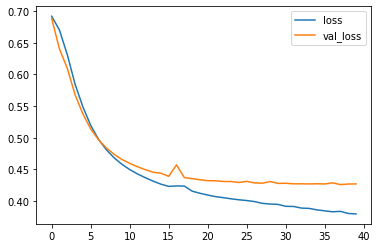

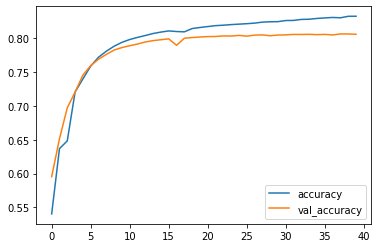

In [0]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()


plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 117)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 117, 20)           5280100   
_________________________________________________________________
lstm (LSTM)                  (None, 117, 15)           2160      
_________________________________________________________________
lstm_1 (LSTM)                (None, 117, 15)           1860      
_________________________________________________________________
lstm_2 (LSTM)                (None, 117, 15)           1860      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16    

In [0]:
# Let's test the model with some of the real-life examples!
pos = ['Oh that looks cool!', 'I love you', 'I like cats', "That's wonderful!", "It looks great!"]
neg = ['I hate you!', "I can't do this anymore", "I don't like dogs", "It's not that good"]
data = pos + neg

test_seq = tokenizer.texts_to_sequences(data)
test_data = pad_sequences(test_seq, maxlen = T)

In [0]:
print(data)
preds = model.predict(test_data).round()

['Oh that looks cool!', 'I love you', 'I like cats', "That's wonderful!", 'It looks great!', 'I hate you!', "I can't do this anymore", "I don't like dogs", "It's not that good"]


In [0]:
print(preds)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [0]:
print('Saving the model...')
name = 'sentiment_analysis'
model.save(name + ".h5")
print('Model saved!')

Saving the model...
Model saved!


In [17]:
print('Saving the tokenizer configuration to json file')
import pickle
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Saved the tokenizer!')

Saving the tokenizer configuration to json file
Saved the tokenizer!
